In [44]:
#Cargamos las bibliotecas
import pandas as pd
import numpy as np
import re
import nltk 
nltk.download('stopwords',quiet=True)
nltk.download('wordnet',quiet=True)
nltk.download('omw-1.4',quiet=True)
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt 
import itertools
from scipy.sparse import issparse

In [45]:
# Definimos la implementación MultinomialNB
class MultinomialNB:
    def __init__(self): #Inicializa el clasificador
        self.trained = 0

    def fit(self, X, y, alpha=1.0): # Entrena el modelo usando la matriz de características X, el vector de etiquetas y, # y el parámetro de suavizado de Laplace alpha.
        self.alpha = alpha 
        if issparse(X):  # Verificamos si X es un objeto disperso; de ser así, lo convertimos a denso
            X = X.toarray()
        y = np.array(y)  # Aseguramos que y es un array NumPy
        
        # Extraemos las clases únicas
        self.K = np.unique(y)
        n_K = len(self.K)
        n_features = X.shape[1]
        
        # Inicializamos el contador de documentos por clase
        self.n_clases = np.zeros(n_K, dtype=np.float64)
        
        # Inicializamos la matriz de conteos de cada caracteristica por cada clase
        self.n_features = np.zeros((n_K, n_features), dtype=np.float64)
        
        # Iteramos sobre cada clase para acumular los conteos
        for id, k in enumerate(self.K):
            
            # Seleccionamos las muestras que pertenecen a la clase actual
            X_c = X[y == k]
            
            # Sumamos las ocurrencias de cada término para esta clase
            self.n_features[id, :] = X_c.sum(axis=0)
            
            # Contamos el número de documentos en esta clase
            self.n_clases[id] = X_c.shape[0]
            
            # Calculamos la probabilidad y luego el logaritmo
        self.log_priors = np.log(self.n_clases / np.sum(self.n_clases))
        
        # Aplicamos el suavizado de Laplace a los conteos de cada característica
        suavizado_fc = self.n_features + self.alpha
        
        # Calculamos el total de ocurrencias (suavizadas) de todas las palabras por clase
        suavizado_cc = suavizado_fc.sum(axis=1)
        
        # Calculamos la log-probabilidad de cada término
        self.log_probs = np.log(suavizado_fc) - np.log(suavizado_cc.reshape(-1, 1))

        # Marcamos el modelo como entrenado
        self.trained = 1
        print("Modelo entrenado con éxito.")
        
    def log_prob_pred(self, X): #Calcula la probabilidad de que cada muestra en X pertenezca a cada clase
        if not self.trained:
            raise ValueError("El modelo no ha sido entrenado.")
        
        if issparse(X):
            X = X.toarray()

        log_probs = X.dot(self.log_probs.T) + self.log_priors
        return log_probs
        
    def predict(self, X): #Predice la clase para cada muestra en X, eligiendo aquella con la mayor log-probabilidad
        if not self.trained:
            raise ValueError("El modelo no ha sido entrenado.")

        # Calculamos las log-probabilidades para cada clase
        log_probs = self.log_prob_pred(X)
        # Para cada muestra, seleccionamos el índice de la clase con mayor log-probabilidad
        return self.K[np.argmax(log_probs, axis=1)]

In [46]:
#Cargamos el dataset
datos = pd.read_csv("Datos/US-Economic-News.csv", encoding='ISO-8859-1')
datos.head()


,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,positivity,positivity:confidence,relevance,relevance:confidence,articleid,date,headline,positivity_gold,relevance_gold,text
0,842613455,False,finalized,3,12/5/15 17:48,3.0,0.6400,yes,0.640,wsj_398217788,8/14/91,Yields on CDs Fell in the Latest Week,NaN,NaN,NEW YORK -- Yields on most certificates of dep...
1,842613456,False,finalized,3,12/5/15 16:54,NaN,NaN,no,1.000,wsj_399019502,8/21/07,The Morning Brief: White House Seeks to Limit ...,NaN,NaN,The Wall Street Journal Online</br></br>The Mo...
2,842613457,False,finalized,3,12/5/15 1:59,NaN,NaN,no,1.000,wsj_398284048,11/14/91,Banking Bill Negotiators Set Compromise --- Pl...,NaN,NaN,WASHINGTON -- In an effort to achieve banking ...
3,842613458,False,finalized,3,12/5/15 2:19,NaN,0.0000,no,0.675,wsj_397959018,6/16/86,Manager's Journal: Sniffing Out Drug Abusers I...,NaN,NaN,The statistics on the enormous costs of employ...
4,842613459,False,finalized,3,12/5/15 17:48,3.0,0.3257,yes,0.640,wsj_398838054,10/4/02,Currency Trading: Dollar Remains in Tight Rang...,NaN,NaN,NEW YORK -- Indecision marked the dollar's ton...


In [47]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   _unit_id               8000 non-null   int64  
 1   _golden                8000 non-null   bool   
 2   _unit_state            8000 non-null   object 
 3   _trusted_judgments     8000 non-null   int64  
 4   _last_judgment_at      8000 non-null   object 
 5   positivity             1420 non-null   float64
 6   positivity:confidence  3775 non-null   float64
 7   relevance              8000 non-null   object 
 8   relevance:confidence   8000 non-null   float64
 9   articleid              8000 non-null   object 
 10  date                   8000 non-null   object 
 11  headline               8000 non-null   object 
 12  positivity_gold        0 non-null      float64
 13  relevance_gold         0 non-null      float64
 14  text                   8000 non-null   object 
dtypes: b

In [48]:
#Contamos la cantidad de "si", "no" y "not sure"
datos['relevance'].value_counts()

relevance
no          6571
yes         1420
not sure       9
Name: count, dtype: int64

In [49]:
#Eliminamos las filas "not sure"
datos = datos[datos.relevance != "not sure"]
datos.shape

(7991, 15)

In [50]:
datos['relevance'].value_counts()

relevance
no     6571
yes    1420
Name: count, dtype: int64

In [51]:
#Convertimos la variable objetivo categórica ('relevance') a formato numérico,"yes"=1 y "no"=0
datos['relevance'] = datos['relevance'].map({'yes':1, 'no':0})

In [52]:
#Nos quedamos solo con las culumnas "text" y "relevance"
datos = datos[['text', 'relevance']]
datos.shape

(7991, 2)

In [53]:
datos.head()

,text,relevance
0,NEW YORK -- Yields on most certificates of dep...,1
1,The Wall Street Journal Online</br></br>The Mo...,0
2,WASHINGTON -- In an effort to achieve banking ...,0
3,The statistics on the enormous costs of employ...,0
4,NEW YORK -- Indecision marked the dollar's ton...,1


In [54]:
lematizador = WordNetLemmatizer()

In [55]:
#limpiamos el texto

def limpieza(texto):
    texto = re.sub(r'[#@]\w+', ' ', texto)       # elimina hashtags y menciones con arroba
    texto = re.sub(r'[^a-zA-Z\s]', ' ', texto)   # elimina simbolos o caracteres especiales
    texto = texto.lower()                        # convierte el texto a minuscula
    texto = re.sub(r' +', ' ', texto).strip()    # elimina espacios en blanco
    texto = re.sub(r'http\S+|www\S+', '', texto) # elimina enlaces
    texto = re.sub(r'[!?\']', '', texto)         # elimina signos de puntuacion
    texto = re.sub(r'</br>', ' ', texto)         # elimina etiquetas HTML
    texto = re.sub(r'-', ' ', texto)             # elimina guiones por un espacio
    tokens = texto.split()
    tokens_lematizados = [lematizador.lemmatize(token) for token in tokens]
    return ' '.join(tokens_lematizados)




In [56]:
#Separamos los datos de entrenamiento y de testeo
X = datos.text
y = datos.relevance
print(X.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

(7991,) (7991,)


In [57]:
#Vectorizamos el texto para convertirlo en una representacion numerica
vector = CountVectorizer(preprocessor=limpieza)

X_train_dtm = vector.fit_transform(X_train)
X_test_dtm = vector.transform(X_test)

In [58]:
#Inicializamos y entrenamos el modelo y predecimos
modelonb= MultinomialNB()
modelonb.fit(X_train_dtm, y_train, alpha=1.0)
y_pred_class = modelonb.predict(X_test_dtm)

Modelo entrenado con éxito.


In [59]:
#Evaluamos el rendimiento del modelo
print("presición: ", accuracy_score(y_test, y_pred_class))

presición:  0.7437437437437437


In [60]:
# Función para visualizar la matriz de confusión
def matriz_de_confusion(cm, classes,normalize=False,title='matrixconfusion',cmap=plt.cm.Blues):
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    umbral = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > umbral else "black")

    plt.tight_layout()
    plt.ylabel('Real',fontsize=10)
    plt.xlabel('Predictiva',fontsize=10)

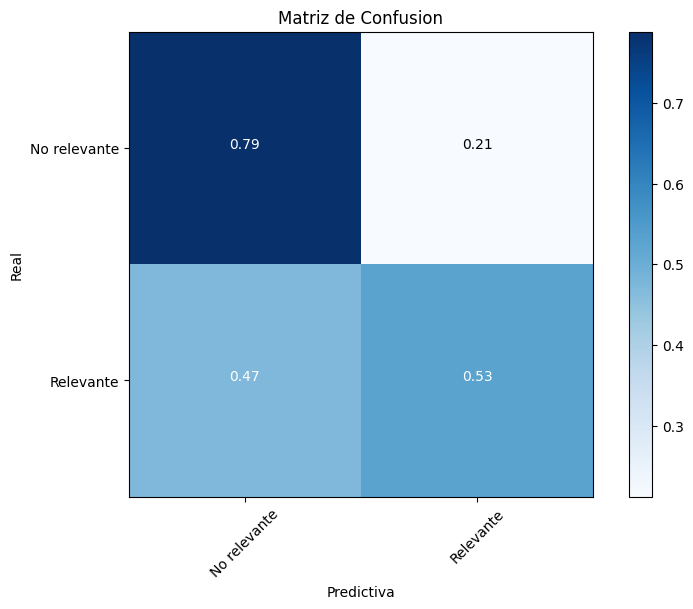

In [61]:
#Graficamos la matriz
graf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8,6))
matriz_de_confusion(graf_matrix, classes=['No relevante','Relevante'],normalize=True,
                      title='Matriz de Confusion')